In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [86]:
df_enc = pd.read_csv("data/enc/data-enc-2024-04-29.csv")

In [87]:
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117767 entries, 0 to 117766
Data columns (total 86 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   avg_price_5                       117767 non-null  float64
 1   bathrooms_total                   117767 non-null  float64
 2   bedrooms_extra                    117767 non-null  float64
 3   bedrooms                          117767 non-null  float64
 4   stories_total                     117767 non-null  float64
 5   size_interior                     117767 non-null  float64
 6   lng                               117767 non-null  float64
 7   lat                               117767 non-null  float64
 8   parkings                          117767 non-null  float64
 9   price                             117767 non-null  float64
 10  household_income                  117767 non-null  float64
 11  individual_income                 117767 non-null  f

In [88]:
df_ON = df_enc[df_enc["province_Ontario"] == True]
df_QC = df_enc[df_enc["province_Quebec"] == True]
df_BC = df_enc[df_enc["province_British Columbia"] == True]
df_AB = df_enc[df_enc["province_Alberta"] == True]
df_SK = df_enc[df_enc["province_Saskatchewan"] == True]
df_MB = df_enc[df_enc["province_Manitoba"] == True]
# East
df_ES = df_enc[(df_enc["province_Nova Scotia"] == True) |
               (df_enc["province_New Brunswick"] == True) |
               (df_enc["province_Newfoundland & Labrador"] == True) |
               (df_enc["province_Prince Edward Island"] == True)]
# North
df_NO = df_enc[(df_enc["province_Yukon"] == True) |
               (df_enc["province_Northwest Territories"] == True)]

df_ON = df_ON.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_QC = df_QC.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_BC = df_BC.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_AB = df_AB.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_SK = df_SK.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_MB = df_MB.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta", "province_Saskatchewan",
                    "province_Manitoba", "province_Nova Scotia", "province_New Brunswick", "province_Newfoundland & Labrador",
                    "province_Prince Edward Island", "province_Yukon", "province_Northwest Territories"], axis=1)
df_ES = df_ES.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta",
                    "province_Saskatchewan","province_Manitoba", "province_Yukon", "province_Northwest Territories"], axis=1)
df_NO = df_NO.drop(["province_Ontario", "province_Quebec", "province_British Columbia", "province_Alberta",
                    "province_Saskatchewan", "province_Manitoba", "province_Nova Scotia", "province_New Brunswick",
                    "province_Newfoundland & Labrador", "province_Prince Edward Island"], axis=1)

In [89]:
df_BC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26541 entries, 27670 to 117758
Data columns (total 74 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   avg_price_5                    26541 non-null  float64
 1   bathrooms_total                26541 non-null  float64
 2   bedrooms_extra                 26541 non-null  float64
 3   bedrooms                       26541 non-null  float64
 4   stories_total                  26541 non-null  float64
 5   size_interior                  26541 non-null  float64
 6   lng                            26541 non-null  float64
 7   lat                            26541 non-null  float64
 8   parkings                       26541 non-null  float64
 9   price                          26541 non-null  float64
 10  household_income               26541 non-null  float64
 11  individual_income              26541 non-null  float64
 12  commute_transit                26541 non-null 

In [90]:
df_BC.corr(numeric_only=True)["price"].sort_values(ascending=False).head(20)

price                         1.000000
avg_price_5                   0.702521
size_interior                 0.576582
bathrooms_total               0.475448
bedrooms                      0.473111
individual_income             0.462737
household_income              0.462737
building_type_House           0.391968
ownership_type_group_ids_1    0.378002
parkings                      0.324365
area_duplex                   0.247853
age_15_to_19                  0.245474
edu_post_graduate_degree      0.238403
multi_family                  0.233485
edu_bachelor_degree           0.233102
single_family                 0.227394
edu_university_certificate    0.188820
lang_other                    0.181085
loc_parks                     0.167922
age_10_to_14                  0.163823
Name: price, dtype: float64

## Raw Input

In [91]:
kf = KFold(n_splits=10)

In [92]:
cb1 = CatBoostRegressor(silent=True)

X = df_BC.drop("price", axis=1)
y = df_BC["price"]

scores1 = cross_val_score(cb1, X, y, cv=kf, scoring="r2")

print(f"\n{scores1}\n")
pd.Series(scores1).describe()


[0.72808662 0.82311918 0.71361769 0.56337756 0.61345724 0.8000227
 0.76648307 0.75771649 0.74119287 0.76834259]



count    10.000000
mean      0.727542
std       0.080847
min       0.563378
25%       0.717235
50%       0.749455
75%       0.767878
max       0.823119
dtype: float64

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cb1.fit(X_train, y_train)
y_pred = cb1.predict(X_test)

In [94]:
r2_score(y_test, y_pred)

0.7356175029161637

In [95]:
root_mean_squared_error(y_test, y_pred)

471929.6066989618

In [96]:
y_df1 = pd.DataFrame({"y_test":y_test.values, "y_pred":y_pred})

In [97]:
np.round(y_df1.head(20))

,y_test,y_pred
0,598000.0,596027.0
1,989000.0,971064.0
2,499999.0,603196.0
3,1298000.0,1528535.0
4,475000.0,513097.0
5,1350000.0,1491037.0
6,1499000.0,1539772.0
7,1739000.0,1832431.0
8,499000.0,600936.0
9,569900.0,614774.0


## Scaled

In [98]:
cb2 = CatBoostRegressor(silent=True)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.to_numpy().reshape(-1,1))

scores2 = cross_val_score(cb2, X_scaled, y_scaled, cv=kf, scoring="r2")

print(f"\n{scores2}\n")
pd.Series(scores2).describe()


[0.72450866 0.82368617 0.71303227 0.56256208 0.6150089  0.79821291
 0.7651479  0.75800114 0.73569221 0.7692015 ]



count    10.000000
mean      0.726505
std       0.080604
min       0.562562
25%       0.715901
50%       0.746847
75%       0.768188
max       0.823686
dtype: float64

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

cb2.fit(X_train, y_train)
y_pred = cb2.predict(X_test)

In [100]:
r2_score(y_test, y_pred)

0.7346253825165678

In [101]:
root_mean_squared_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_pred.reshape(-1,1)))

472814.2578499246

In [102]:
y_df2 = pd.DataFrame({"y_test":scaler_y.inverse_transform(y_test[:,0].reshape(-1,1))[:,0].tolist(),
                      "y_pred":scaler_y.inverse_transform(y_pred.reshape(-1,1))[:,0].tolist()})

In [103]:
np.round(y_df2.head(20))

,y_test,y_pred
0,598000.0,575319.0
1,989000.0,973134.0
2,499999.0,614533.0
3,1298000.0,1615337.0
4,475000.0,508030.0
5,1350000.0,1510397.0
6,1499000.0,1523113.0
7,1739000.0,1764055.0
8,499000.0,614386.0
9,569900.0,613666.0


## log1p: X Only

In [104]:
from scipy import stats

sub_df = df_AB.copy(deep=True)

skew_df = pd.DataFrame(sub_df.columns, columns=["Feature"])
skew_df["Corr_Price_Before"] = sub_df.corr()["price"].values
skew_df["Skew_Before"] = skew_df["Feature"].apply(lambda feature: stats.skew(sub_df[feature]))
skew_df["AbsSkew_Before"] = skew_df["Skew_Before"].apply(abs)
skew_df["Skewed_Before"] = skew_df["AbsSkew_Before"].apply(lambda x: True if x>= 0.5 else False)

# before_log = set(skew_df.query("Skewed_Before == True")["Feature"].values)

for column in skew_df.query("Skewed_Before == True")["Feature"].values:
    if column != "price":
        sub_df[column] = np.log1p(sub_df[column])


# skew_df = pd.DataFrame(sub_df.columns, columns=["Feature"])
skew_df["Corr_Price_After"] = sub_df.corr()["price"].values
skew_df["Skew_After"] = skew_df["Feature"].apply(lambda feature: stats.skew(sub_df[feature]))
skew_df["AbsSkew_After"] = skew_df["Skew_After"].apply(abs)
skew_df["Skewed_After"] = skew_df["AbsSkew_After"].apply(lambda x: True if x>= 0.5 else False)

# after_log = set(skew_df.query("Skewed_Before == True")["Feature"].values)

# log_columns = list(before_log - after_log - {"price", "lng", "lat"})
log_columns = skew_df[(skew_df["Skewed_Before"]==True) & (skew_df["Corr_Price_After"] > skew_df["Corr_Price_Before"])]["Feature"].values

log_columns

/home/soheil/codes/House-Pred-CA/House-Pred-CA/.venv/lib64/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


array(['bedrooms_extra', 'commute_transit', 'commute_drive',
       'lang_en_only', 'lang_en_and_fr', 'area_apt_5_plus_floors',
       'loc_transit_friendly', 'loc_wellness',
       'building_type_Row / Townhouse', 'building_type_Semi-Detached',
       'ownership_type_group_ids_0', 'ownership_type_group_ids_1',
       'ownership_type_group_ids_2'], dtype=object)

In [105]:
cb3 = CatBoostRegressor(silent=True)

X_log = X.copy(deep=True)
X_log[log_columns] = np.log1p(X_log[log_columns])

X_scaled = scaler_X.fit_transform(X_log)
y_scaled = scaler_y.fit_transform(y.to_numpy().reshape(-1,1))

scores3 = cross_val_score(cb3, X_scaled, y_scaled, cv=kf, scoring="r2")

print(f"\n{scores3}\n")
pd.Series(scores3).describe()


[0.72450866 0.82368617 0.71303227 0.56255247 0.6150089  0.79821291
 0.7651479  0.75800267 0.73569221 0.76924964]



count    10.000000
mean      0.726509
std       0.080609
min       0.562552
25%       0.715901
50%       0.746847
75%       0.768224
max       0.823686
dtype: float64

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

cb3.fit(X_train, y_train)
y_pred = cb3.predict(X_test)

In [107]:
r2_score(y_test, y_pred)

0.7346253825165678

In [108]:
root_mean_squared_error(y_test, y_pred)

0.523109281095537

In [109]:
y_df3 = pd.DataFrame({"y_test":scaler_y.inverse_transform(y_test[:,0].reshape(-1,1))[:,0].tolist(),
                      "y_pred":scaler_y.inverse_transform(y_pred.reshape(-1,1))[:,0].tolist()})

In [110]:
np.round(y_df3.head(20))

,y_test,y_pred
0,598000.0,575319.0
1,989000.0,973134.0
2,499999.0,614533.0
3,1298000.0,1615337.0
4,475000.0,508030.0
5,1350000.0,1510397.0
6,1499000.0,1523113.0
7,1739000.0,1764055.0
8,499000.0,614386.0
9,569900.0,613666.0


# log1p: X and y

In [111]:
cb4 = CatBoostRegressor(silent=True)

X_log = X.copy(deep=True)
X_log[log_columns] = np.log1p(X_log[log_columns])

y_log = np.log1p(y)

X_scaled = scaler_X.fit_transform(X_log)
y_scaled = scaler_y.fit_transform(y_log.to_numpy().reshape(-1,1))

scores4 = cross_val_score(cb4, X_scaled, y_scaled, cv=kf, scoring="r2")

print(f"\n{scores4}\n")
pd.Series(scores4).describe()


[0.78924502 0.90531207 0.87960477 0.82804308 0.73181684 0.8764366
 0.88113545 0.87893002 0.85052185 0.88543594]



count    10.000000
mean      0.850648
std       0.053576
min       0.731817
25%       0.833663
50%       0.877683
75%       0.880753
max       0.905312
dtype: float64

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

cb4.fit(X_train, y_train)
y_pred = cb4.predict(X_test)

In [113]:
r2_score(y_test, y_pred)

0.8724800651174777

### Reverse Log

In [114]:
r2_score(np.expm1(y_test), np.expm1(y_pred))

0.5065475277745886

In [115]:
root_mean_squared_error(y_test, y_pred)

0.35601091952882163

In [116]:
y_df4 = pd.DataFrame({"y_test":np.expm1(scaler_y.inverse_transform(y_test))[:,0].tolist(),
                      "y_pred":np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1,1))[:,0].tolist())})

In [117]:
np.round(y_df4.head(20))

,y_test,y_pred
0,598000.0,552274.0
1,989000.0,954264.0
2,499999.0,528295.0
3,1298000.0,1574494.0
4,475000.0,522825.0
5,1350000.0,1574733.0
6,1499000.0,1516316.0
7,1739000.0,1752809.0
8,499000.0,576175.0
9,569900.0,601493.0


In [118]:
np.round(y_df3.head(20))

,y_test,y_pred
0,598000.0,575319.0
1,989000.0,973134.0
2,499999.0,614533.0
3,1298000.0,1615337.0
4,475000.0,508030.0
5,1350000.0,1510397.0
6,1499000.0,1523113.0
7,1739000.0,1764055.0
8,499000.0,614386.0
9,569900.0,613666.0


/tmp/ipykernel_2906/305300287.py:2: RuntimeWarning: overflow encountered in expm1
  plt.scatter(np.expm1(scaler_X.inverse_transform(X_test))[:,5], np.expm1(scaler_y.inverse_transform(y_test)))
/tmp/ipykernel_2906/305300287.py:3: RuntimeWarning: overflow encountered in expm1
  plt.scatter(np.expm1(scaler_X.inverse_transform(X_test))[:,5], np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1,1))))


/home/soheil/codes/House-Pred-CA/House-Pred-CA/.venv/lib64/python3.12/site-packages/matplotlib/ticker.py:2096: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


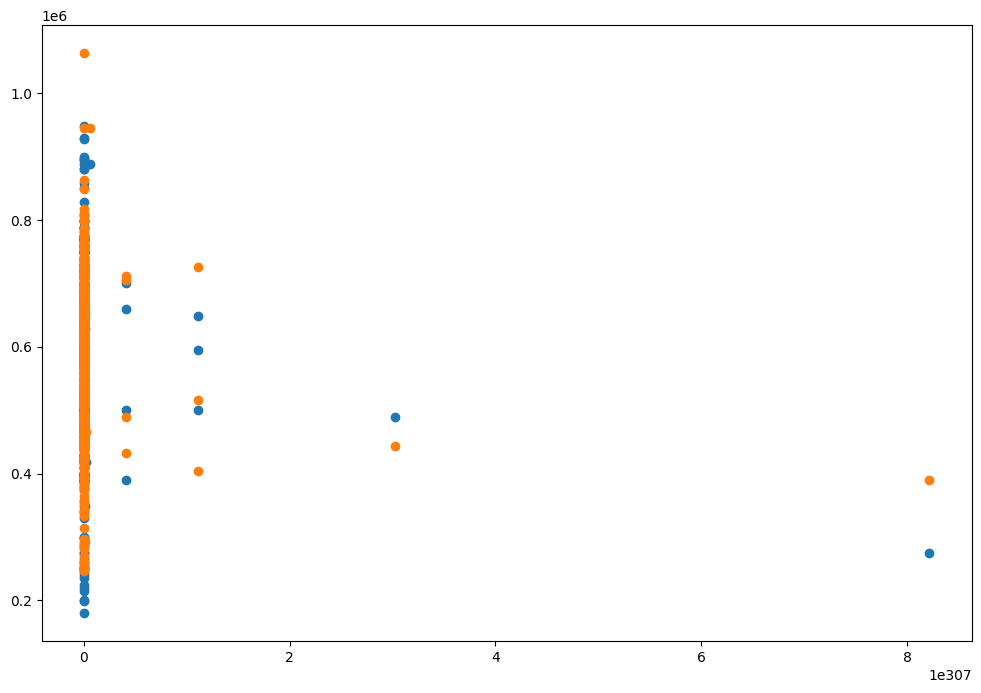

In [119]:
plt.figure(figsize=(12,8))
plt.scatter(np.expm1(scaler_X.inverse_transform(X_test))[:,5], np.expm1(scaler_y.inverse_transform(y_test)))
plt.scatter(np.expm1(scaler_X.inverse_transform(X_test))[:,5], np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1,1))))

In [120]:
r2_score(np.expm1(scaler_y.inverse_transform(y_test)), np.expm1(scaler_y.inverse_transform(y_pred.reshape(-1,1))))

0.7286537503738202

In [121]:
X_log

,avg_price_5,bathrooms_total,bedrooms_extra,bedrooms,stories_total,size_interior,lng,lat,parkings,household_income,...,loc_cafes,loc_quiet,loc_parks,building_type_Apartment,building_type_House,building_type_Row / Townhouse,building_type_Semi-Detached,ownership_type_group_ids_0,ownership_type_group_ids_1,ownership_type_group_ids_2
27670,842200.0,2.0,0.0,2.0,1.0,1117.0,-125.548371,48.940323,0.0,99881.35900,...,2.5,5.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.000000,0.693147
27671,834580.0,1.0,0.0,1.0,1.0,758.0,-125.433986,48.959021,2.0,110905.34526,...,0.0,5.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.693147,0.000000
27672,876400.0,2.0,0.0,2.0,1.0,1200.0,-125.529954,48.924052,0.0,122000.00000,...,0.5,5.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.693147
27673,676400.0,2.0,0.0,2.0,1.0,988.0,-125.553330,48.944657,0.0,95000.00000,...,2.5,4.5,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.693147
27674,920400.0,2.0,0.0,2.0,1.0,1117.0,-125.536354,48.929734,1.0,122000.00000,...,1.5,5.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117643,599800.0,2.0,0.0,3.0,1.0,1577.0,-126.640539,54.393580,0.0,122294.86460,...,2.5,5.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.693147,0.000000
117672,324920.0,1.0,0.0,3.0,1.0,1222.0,-120.236282,55.765932,1.0,103139.35930,...,2.0,5.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.693147,0.000000
117673,319760.0,2.0,0.0,3.0,1.0,2372.0,-120.255952,55.773853,4.0,131594.92420,...,1.0,5.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.693147,0.000000
117719,258720.0,2.0,0.0,2.0,1.0,1163.0,-120.867792,56.250667,0.0,151093.86670,...,2.0,5.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.693147


In [122]:
y

27670      679900.0
27671      469000.0
27672     1049000.0
27673      819000.0
27674      829000.0
            ...    
117643     439900.0
117672     315000.0
117673     359900.0
117719     282000.0
117758     369900.0
Name: price, Length: 26541, dtype: float64

In [123]:
df_log = X_log.copy(deep=True)
df_log["price_log"] = np.log1p(y)

In [124]:
df_log.corr(numeric_only=True)["price_log"].sort_values(ascending=False).head(20)

price_log                     1.000000
avg_price_5                   0.722232
size_interior                 0.651404
bedrooms                      0.579062
bathrooms_total               0.577692
household_income              0.478485
individual_income             0.478485
building_type_House           0.446054
ownership_type_group_ids_1    0.427786
parkings                      0.382218
area_duplex                   0.317717
single_family                 0.309257
multi_family                  0.302629
edu_bachelor_degree           0.280741
age_15_to_19                  0.278959
edu_post_graduate_degree      0.277289
lang_other                    0.234182
edu_university_certificate    0.232302
loc_parks                     0.223976
age_10_to_14                  0.202834
Name: price_log, dtype: float64

In [125]:
X.columns

Index(['avg_price_5', 'bathrooms_total', 'bedrooms_extra', 'bedrooms',
       'stories_total', 'size_interior', 'lng', 'lat', 'parkings',
       'household_income', 'individual_income', 'commute_transit',
       'commute_foot', 'commute_bicycle', 'commute_drive', 'single_family',
       'multi_family', 'single_person', 'multi_person', 'total_individuals',
       'age_0_to_4', 'age_5_to_9', 'age_10_to_14', 'age_15_to_19',
       'age_20_to_34', 'age_35_to_49', 'age_50_to_64', 'age_65_to_79',
       'age_80_plus', 'owners', 'renters', 'lang_en_only', 'lang_fr_only',
       'lang_en_and_fr', 'lang_other', 'edu_no_high_school', 'edu_high_school',
       'edu_trade_certificate', 'edu_college_certificate',
       'edu_university_certificate', 'edu_bachelor_degree',
       'edu_post_graduate_degree', 'household_children',
       'area_single_detached', 'area_semi_detached', 'area_duplex',
       'area_row_houses', 'area_apt_1_to_4_floors', 'area_apt_5_plus_floors',
       'loc_high_schools', 